In [1]:
import gym
import envs.bandits

import numpy as np
import torch

from tqdm import tqdm, trange
import types
import math

from utils import load_csv, kalman_filter

from models.probit import LaplaceProbitRegression
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
import umap

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import seaborn as sns
from pylab import rcParams

/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
num_steps = 10
env = gym.make('GaussianBandit-v1')
env.batch_size = 1

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
num_models = 10
file_names = ['trained_models/models_0911/512/' + str(i+1) + '_0.pt' for i in range(num_models)] \
                + ['trained_models/models_0911/1024/' + str(i+1) + '_0.pt' for i in range(num_models)] \
                + ['trained_models/models_0911/2048/' + str(i+1) + '_0.pt' for i in range(num_models)] \
                + ['trained_models/models_0911/4096/' + str(i+1) + '_0.pt' for i in range(num_models)] \
                + ['trained_models/models_0911/8192/' + str(i+1) + '_0.pt' for i in range(num_models)] \
                #['trained_models/models_0911/256/' + str(i+1) + '_0.pt' for i in range(num_models)] \

In [4]:
# save to format as in Gershman (2018)
num_models = len(file_names)
model_samples = 100
env.max_steps = 10
num_blocks = 200

records = np.empty((num_models * env.max_steps * num_blocks, 8))
step = 0

for i, file_name in enumerate(file_names):
    try:
        N, t, model = torch.load(file_name)

        fmt = ",".join(["%d"] + ["%d"] + ["%d"] + ["%.3f"] + ["%.3f"] + ["%d"] + ["%.3f"] + ["%.3f"])

        T = trange(num_blocks)
        for t in T:
            obs = env.reset()
            env.max_steps = 10
            hx = [model.initial_states(1) for k in range(model_samples)]
            zeta = [model.get_zeta(1) for k in range(model_samples)]
            done = False

            while not done:
                action_model = 0
                for m in range(model_samples):
                    q_mu, _, hx[m] = model(obs, hx[m], zeta[m])
                    action_model += torch.argmax(q_mu[0]).float().item()
                    
                action_model = action_model / model_samples
                action = torch.ones(1).long() if action_model > 0.5 else torch.zeros(1).long()

                obs, reward, done, info = env.step(action)
                action = action.item()
                reward = reward.item()
                records[step, 0] = int(i) + 1
                records[step, 1] = int(t) + 1
                records[step, 2] = env.t
                records[step, 3] = env.mean[0, 0]
                records[step, 4] = env.mean[0, 1]
                records[step, 5] = action + 1
                records[step, 6] = reward
                records[step, 7] = 0
                step += 1

    except Exception as inst:
        print(inst)

np.savetxt('data/net1.csv', records, fmt=fmt, header="subject,block,trial,mu1,mu2,choice,reward,RT", comments='')

/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.mdlrdqn.MDLRDQN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.recurrent.GroupHSGRUCell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/marcel/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.linear.LinearGroupHS' has changed. you can retrieve the original source code b

In [5]:
Q = [10, 100, 100];

# load in human data
current_data = load_csv('data/data2.csv')
latents_human = np.empty((1, len(current_data)), dtype=object)

for s in range(len(current_data)):
    latents_human[0, s] = kalman_filter(Q, current_data[0, s])
    
titles = ['Subject ' + str(i) for i in range(latents_human.shape[1])]

b_human = np.zeros((latents_human.shape[1], 3))
human_stds = np.zeros((latents_human.shape[1], 3))
for s in range(latents_human.shape[1]):
    S = np.sqrt(latents_human[0, s]['s'][:, 0] + latents_human[0, s]['s'][:, 1])
    Sm = np.sqrt(latents_human[0, s]['s'][:, 0]) - np.sqrt(latents_human[0, s]['s'][:, 1])
    V = latents_human[0, s]['m'][:, 0] - latents_human[0, s]['m'][:, 1]
    C = (current_data[0, s]['c'] == 1)[:, 0].astype(float)
    X = np.stack([V, Sm, V/S]).T
    pr = LaplaceProbitRegression(3)
    b_human[s, :] = pr.fit(X, C)
    human_stds[s, :] = pr.hessian(X, C)

In [6]:
# load in model data
current_data = load_csv('data/net1.csv')
latents_model = np.empty((1, len(current_data)), dtype=object)

for s in range(len(current_data)):
    latents_model[0, s] = kalman_filter(Q, current_data[0, s])
    
titles = titles + ['Model ' + str(i) for i in range(latents_model.shape[1])]

b_model = np.zeros((latents_model.shape[1], 3))
for s in range(latents_model.shape[1]):
    S = np.sqrt(latents_model[0, s]['s'][:, 0] + latents_model[0, s]['s'][:, 1])
    Sm = np.sqrt(latents_model[0, s]['s'][:, 0]) - np.sqrt(latents_model[0, s]['s'][:, 1])
    V = latents_model[0, s]['m'][:, 0] - latents_model[0, s]['m'][:, 1]
    C = (current_data[0, s]['c'] == 1)[:, 0].astype(float)
    X = np.stack([V, Sm, V/S]).T
    pr = LaplaceProbitRegression(3)
    b_model[s, :] = pr.fit(X, C)
    
b = np.concatenate((b_human, b_model))
np.save('data/all_coefficients.npy', b)

# umap embedding
trans = umap.UMAP(n_neighbors=16).fit(b)

# mean shift clustering
clustering = KMeans(3).fit(trans.embedding_)

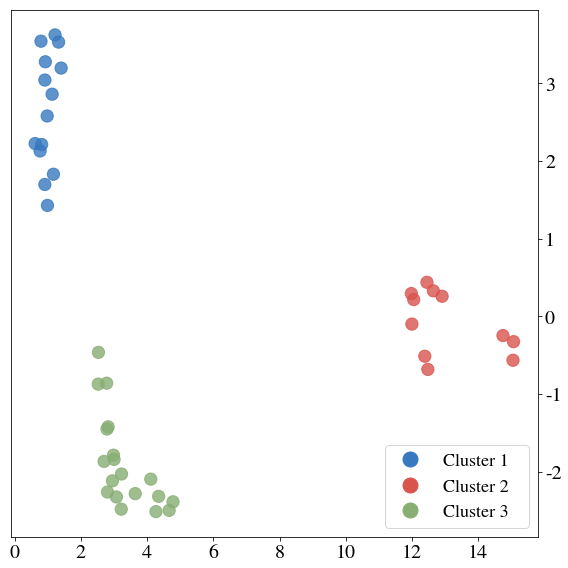

In [13]:
# visualize human embedding
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


cm = clustering.labels_[:b_human.shape[0]]
colormap = LinearSegmentedColormap.from_list('test', [sns.xkcd_rgb["windows blue"], \
                                                      sns.xkcd_rgb["pale red"], \
                                                      sns.xkcd_rgb["sage"]], N=3)

plt.scatter(trans.embedding_[:b_human.shape[0], 0], trans.embedding_[:b_human.shape[0], 1], alpha=0.8, s=150, c=cm, cmap=colormap)
plt.xticks(np.arange(0, 16, 2), np.arange(0, 16, 2), fontsize=20 )
plt.yticks(np.arange(-2, 4, 1), np.arange(-2, 4, 1), fontsize=20 )
#plt.xlim(-9, 15)
#plt.ylim(-7, 0)
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', right='on', left='off')

custom_lines = [Line2D([0], [0], color=sns.xkcd_rgb["windows blue"], markersize=15, lw=4, marker='o', linestyle=''),
                Line2D([0], [0], color=sns.xkcd_rgb["pale red"], markersize=15, lw=4, marker='o', linestyle=''),
                Line2D([0], [0], color=sns.xkcd_rgb["sage"], markersize=15, lw=4, marker='o', linestyle='')]
plt.legend(custom_lines, ['Cluster 1   ', 'Cluster 2   ', 'Cluster 3   '], prop={'size': 18}, loc=4)


plt.tight_layout()
plt.savefig('human.pdf', bbox_inches='tight')

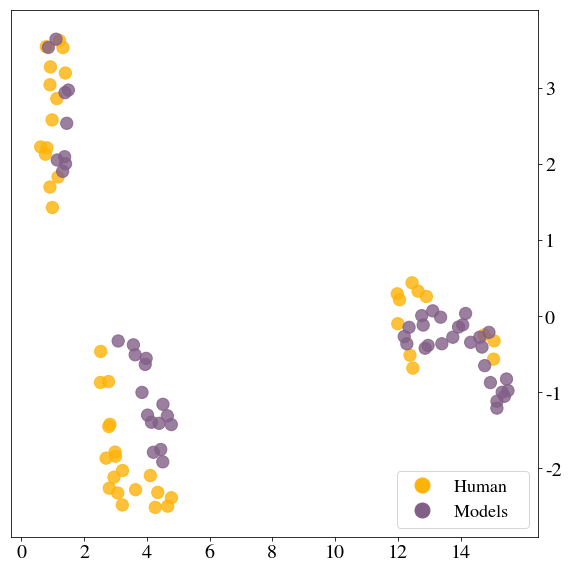

In [14]:
# visualize joint embedding
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
cm = np.ones(b.shape[0])
cm[:b_human.shape[0]] = 0

plt.xticks(np.arange(0, 16, 2), np.arange(0, 16, 2), fontsize=20 )
plt.yticks(np.arange(-2, 4, 1), np.arange(-2, 4, 1), fontsize=20 )
#plt.xlim(-9, 15)
#plt.ylim(-7, 0)
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', right='on', left='off')
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=150, alpha=0.8, c=cm, cmap=LinearSegmentedColormap.from_list('test', [sns.xkcd_rgb["amber"], sns.xkcd_rgb["dusty purple"]], N=2)) #
custom_lines = [Line2D([0], [0], color=sns.xkcd_rgb["amber"], markersize=15, lw=4, marker='o', linestyle=''),
                Line2D([0], [0], color=sns.xkcd_rgb["dusty purple"], markersize=15, lw=4, marker='o', linestyle='')]
plt.legend(custom_lines, ['Human   ', 'Models   '], prop={'size': 18}, loc=4)

plt.tight_layout()
plt.savefig('model.pdf', bbox_inches='tight')

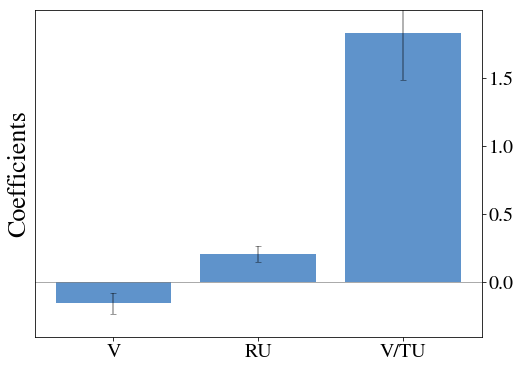

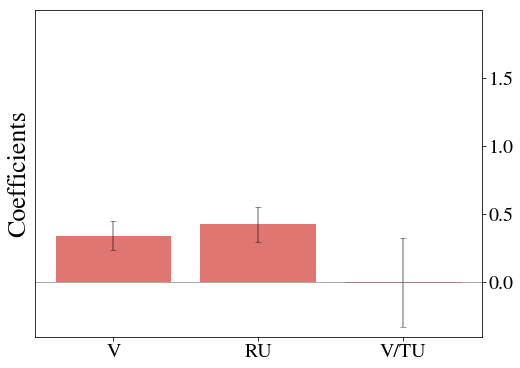

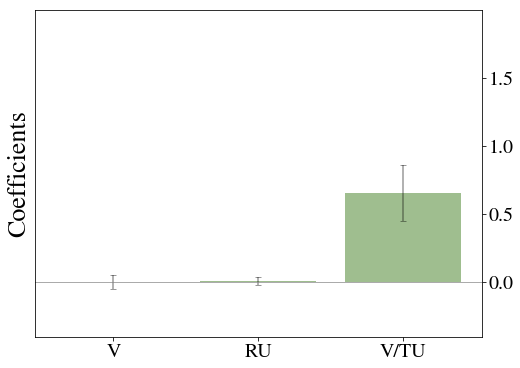

In [24]:
plt.rcParams["figure.figsize"] = (8.0, 6.0)
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
cm = clustering.labels_[:b_human.shape[0]]
colors = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["sage"]]
for i in range(3):
    plt.xticks(np.arange(3), ['V', 'RU', 'V/TU'], fontsize=20 )
    plt.ylim([-0.4, 2.0])
    plt.yticks([0.0, 0.5, 1.0, 1.5], [0.0, 0.5, 1.0, 1.5], fontsize=20)
    plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', right='on', left='off')
    plt.axhline(y=0,linewidth=1, color='grey', alpha=0.66)
    plt.bar(np.arange(3), b_human[cm==i, :][0, :], color=colors[i], error_kw=dict(alpha=0.4), yerr=human_stds[cm==i, :][0, :], align='center', ecolor='black', alpha=0.8, capsize=3)
    plt.ylabel('Coefficients', fontsize=26)
    plt.savefig(str(i) + 'example.pdf', bbox_inches='tight')
    plt.show()
